In [3]:
from scegot import scEGOT
from paths import PROJECT_FOLDER
import scanpy as sc
import numpy as np
import pandas as pd
from scCFM.models.cfm.components.eval.distribution_distances import compute_distribution_distances

from notebooks.utils import decode_trajectory_single_step, standardize, compute_prdc
from tqdm import tqdm
import torch

In [4]:
def update_dict(ref, tgt):
    """
    Update a dictionary with the values of another 
    """
    for key in tgt:
        if key not in ref:
            ref[key] = []
        ref[key].append(tgt[key])
    return ref

Initialize VAEs 

In [5]:
# vae_kwargs={'in_dim': datamodule.in_dim,
#        'n_epochs_anneal_kl': 1000, 
#        'kl_weight': None, 
#        'likelihood': 'nb', 
#        'dropout': False, 
#        'learning_rate': 0.001, 
#        'dropout_p': False, 
#        'model_library_size': True, 
#        'batch_norm': True, 
#        'kl_warmup_fraction': 0.1, 
#        'hidden_dims': [256, 10]}
        
# geometric_kwargs={'compute_metrics_every': 1, 
#            'use_c': True, 
#            'trainable_c': False,
#            'l2': True, 
#            'eta_interp': 0, 
#            'interpolate_z': False, 
#            'start_jac_after': 0, 
#            'fl_weight': 0.1,
#            'detach_theta': True}

# geodesic_kwargs={"in_dim": datamodule.in_dim,
#           "hidden_dims": [256, 10],
#           "batch_norm": True,
#           "dropout": False, 
#           "dropout_p": False,
#           "likelihood": "nb",
#           "learning_rate": 0.001}

# # Initialize vae and geometric vae
# vae = GeometricNBVAE(**geometric_kwargs, vae_kwargs=vae_kwargs).to(device)
# geometric_vae = GeometricNBVAE(**geometric_kwargs, vae_kwargs=vae_kwargs).to(device)
# geodesic_ae = GeodesicAE(**geodesic_kwargs).to(device)

# # Load state dicts and put in eval mode 
# vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_vae_lib.ckpt")["state_dict"])
# geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_geometric_lib.ckpt")["state_dict"])
# geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_geodesic_ae.ckpt")["state_dict"])

Read dataset 

In [6]:
adata_hein = sc.read_h5ad("/home/icb/alessandro.palma/environment/scCFM/project_dir/data/hein_et_al/processed/unperturbed_time_course_host.h5ad")

In [7]:
adata_hein.obs.cluster.unique()

['bystander', 'infected_6', 'infected_4', 'infected_3', 'infected_2', 'infected_1', 'infected_5', 'naive', 'infected_abortive']
Categories (9, object): ['bystander', 'infected_1', 'infected_2', 'infected_3', ..., 'infected_5', 'infected_6', 'infected_abortive', 'naive']

In [8]:
idx2time = {}
leaveout = []
for id, time in enumerate(np.unique(adata_hein.obs.experimental_time)):
    idx2time[id] = time

## For loop interpolations 

Fixed parameters 

In [9]:
RANDOM_STATE = 42
PCA_N_COMPONENTS = 50
GMM_CLUSTER_NUMBERS = [1, 2, 3, 4, 5, 6, 7, 8, 9]
UMAP_N_NEIGHBORS = 30

Initialize model 

In [10]:
scegot = scEGOT(
    adata_hein,
    verbose=True,  # default=True
    adata_day_key="experimental_time",
)

Processing AnnData...


Preprocessing

In [11]:
X, pca_model = scegot.preprocess(50,
                                 recode_params={},
                                 umi_target_sum=1e5,
                                 pca_random_state=42,
                                 pca_other_params={},
                                 apply_recode=False,
                                 apply_normalization_log1p=False,
                                 apply_normalization_umi=False,
                                 select_genes=False,
                                 n_select_genes=2000,
                                 )

Applying PCA...
	sum of explained_variance_ratio = 44.52221508939938


In [12]:
gmm_models, gmm_labels = scegot.fit_predict_gmm(
    n_components_list=GMM_CLUSTER_NUMBERS,
    covariance_type="full",
    max_iter=2000,
    n_init=10,
    random_state=42,
    gmm_other_params={},
    use_pca=False
)

Fitting GMM models with each day's data and predicting labels for them...


100%|██████████| 8/8 [09:40<00:00, 72.55s/it]


In [13]:
# LATENT SPACE METRICS
leaveout_ckpt_latent = {}

# DATA SPACE METRICS
leaveout_ckpt_data= {}

for lt in tqdm([1,2,3,4,5,6]):
    # Take time data frame
    adata_time = adata_hein[adata_hein.obs["experimental_time"]==idx2time[lt]]
    X_interpolation = scegot.make_interpolation_data(gmm_models[lt-1],
                                                        gmm_models[lt+1],
                                                        t=0.5,
                                                        columns=None, 
                                                        n_samples=adata_time.shape[0])
    X_interpolation = np.array(X_interpolation)

    # AnnData of interpolations 
    adata_interpolation = sc.AnnData(X=X_interpolation)
    # Save into normalized layer
    adata_interpolation.layers["X_norm"] = np.exp(X_interpolation)-1
    # Compute PCA
    sc.tl.pca(adata_interpolation) 
    
    
    d_dist_vae_d = compute_prdc(adata_interpolation.obsm["X_pca"], 
                                adata_time.obsm["X_pca"], 
                                nearest_k=10)

    t_adata_time = torch.tensor(adata_time.layers["X_norm"].A[:,None,:])
    t_X_interpolation = torch.tensor(adata_interpolation.layers["X_norm"][:,None,:])

    d_distrib =  compute_distribution_distances(t_adata_time.float(), 
                                                t_X_interpolation.float())
    
    d_distrib = dict(zip(d_distrib[0], d_distrib[1]))

    leaveout_ckpt_data = update_dict(leaveout_ckpt_data, d_dist_vae_d)
    leaveout_ckpt_data = update_dict(leaveout_ckpt_data, d_distrib)

100%|██████████| 6/6 [23:24<00:00, 234.07s/it]


In [14]:
pd.DataFrame(leaveout_ckpt_data).mean(0)

precision        3.849045e-01
recall           4.283427e-01
density          3.307070e-01
coverage         2.452647e-01
1-Wasserstein    2.820538e+01
2-Wasserstein    2.909652e+01
Linear_MMD       4.497897e+02
Poly_MMD         1.714950e+06
RBF_MMD          8.146344e-02
Mean_MSE         1.525205e-01
Mean_L2          3.550579e-01
Mean_L1          1.718909e-01
Median_MSE       1.533050e-01
Median_L2        3.710047e-01
Median_L1        2.092766e-01
dtype: float64

Plots

In [16]:
real_generated_adata = sc.AnnData(X=np.concatenate([X_interpolation, adata_time.X.A]))
label = ["Interp" for _ in range(len(X_interpolation))] + ["Real" for _ in range(len(adata_time))]
label = pd.DataFrame(label)
label.columns = ["dataset_type"] 
real_generated_adata.obs = label

In [17]:
sc.tl.pca(real_generated_adata)
sc.pp.neighbors(real_generated_adata)
sc.tl.umap(real_generated_adata)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



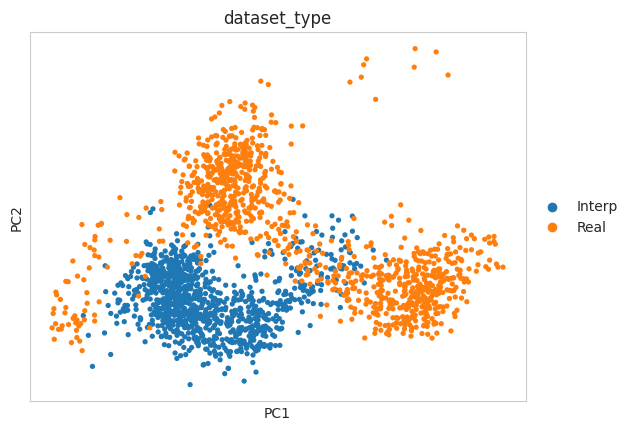

In [18]:
sc.pl.pca(real_generated_adata, color="dataset_type")

In [19]:
t_adata_time.max()

tensor(23.4388)

In [20]:
t_X_interpolation.max()

tensor(11.1495, dtype=torch.float64)